# Predictive Modelling - Students' Performance Dataset
- **Dataset card:** https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset

### **Objectives**
Assess **NON teaching-related factors** affecting student academic performance.
- **Perform multiple linear regression** to obtain evaluation metrics like combined adjusted R-squared and RMSE for good gauge of how much "other factors" influence variability of GPA.
- **Perform multiple linear regression** for strength of coefficients: For feature importance **Check!*
- **[If time permits] Perform tree-based regression** modelling for feature importances.

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df_path = '/content/drive/MyDrive/Colab Notebooks/Interview_25/data/student_performance_final.csv'
df = pd.read_csv(df_path)
df.head()

Mounted at /content/drive


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,Female,Caucasian,2. Some College,19.833723,7,Yes,2. Moderate,No,No,Yes,No,2.929196,2.0
1,1002,18,Male,Caucasian,1. High School,15.408756,0,No,1. Low,No,No,No,No,3.042915,1.0
2,1003,15,Male,Asian,3. Bachelors,4.210570,26,No,2. Moderate,No,No,No,No,0.112602,4.0
3,1004,17,Female,Caucasian,3. Bachelors,10.028829,14,No,3. High,Yes,No,No,No,2.054218,3.0
4,1005,17,Female,Caucasian,2. Some College,4.672495,17,Yes,3. High,No,No,No,No,1.288061,4.0


In [2]:
# Drop student id
df.drop(columns=['StudentID'], inplace=True)

Text(0, 0.5, 'Count')

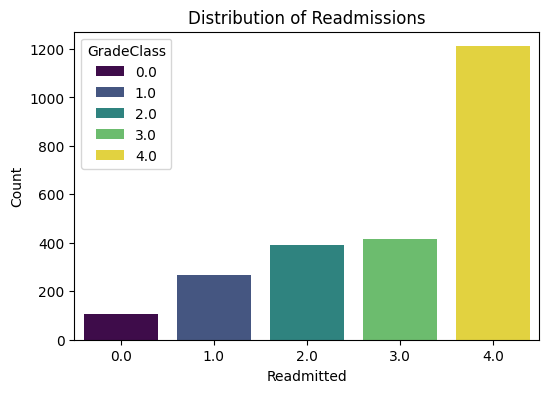

In [3]:
# Preview counts of GradeClass - Ascending
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='GradeClass', hue='GradeClass', palette='viridis')

plt.title('Distribution of Readmissions')
plt.xlabel('Readmitted')
plt.ylabel('Count')

Text(0.5, 0, 'GPA')

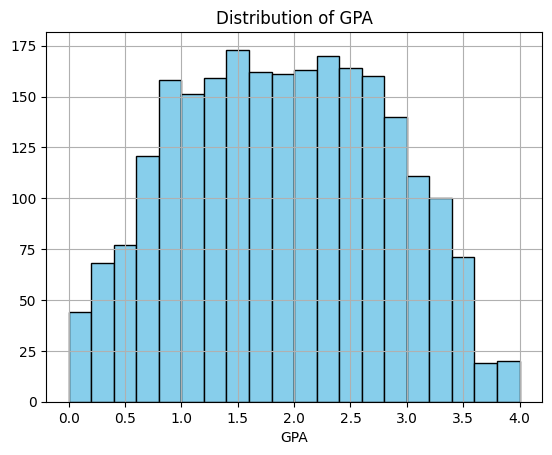

In [4]:
# Distribution of GPA
df['GPA'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of GPA')
plt.xlabel('GPA')

### Predictive Modelling - Simple Linear Regression without Regularization
**Note:** Adjusted R-squared is a modified version of R-squared that accounts for the number of predictors in a regression model. It helps prevent overfitting by penalizing the model for including too many irrelevant variables as predictors. I.e. Adjusts downward if the added predictor doesn’t improve the model enough to justify its inclusion.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tabulate import tabulate

In [6]:
def run_linear_regression_model(df, target, test_size=0.2, n_iter=10):
    """Runs a linear regression model with random search hyperparameter tuning. """

    # 1. Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # 2. Identify numeric and categorical features
    num_cols = X.select_dtypes(include='number').columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    # 3. Define preprocessing pipeline
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ])

    # 4. Full pipeline with Linear Regression
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # 5. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # 6. Random search for basic LinearRegression hyperparams
    param_dist = {
        'regressor__fit_intercept': [True, False],
    }

    search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist,
        n_iter=n_iter, scoring='r2', cv=5, random_state=42
    )
    search.fit(X_train, y_train)

    # 7. Evaluate performance
    y_pred = search.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    n, p = X_test.shape
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # 8. Extract feature coefficients
    final_model = search.best_estimator_

    # Get feature names after preprocessing
    feature_names = (
        num_cols +
        list(final_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_cols))
    )
    coefs = final_model.named_steps['regressor'].coef_

    # Create coefficient DataFrame and sort
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    })
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')

    # 9. Tabulate results
    results = [
        ['R-squared', f'{r2:.4f}'],
        ['Adjusted R-squared', f'{adj_r2:.4f}'],
        ['RMSE', f'{rmse:.4f}']
    ]

    print("\nModel Performance Metrics:")
    print(tabulate(results, headers=['Metric', 'Value'], tablefmt='pretty'))

    print("\nFeature Importances (from strongest to weakest):")
    print(tabulate(coef_df.head(7), headers='keys', tablefmt='pretty', showindex=False))

In [7]:
# Implement Linear Regression
run_linear_regression_model(df, target='GPA', test_size=0.2, n_iter=5)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Model Performance Metrics:
+--------------------+--------+
|       Metric       | Value  |
+--------------------+--------+
|     R-squared      | 0.9570 |
| Adjusted R-squared | 0.9558 |
|        RMSE        | 0.1886 |
+--------------------+--------+

Feature Importances (from strongest to weakest):
+------------------------------+---------------------+
|           Feature            |     Coefficient     |
+------------------------------+---------------------+
|           Absences           | -0.7884649912978374 |
| ParentalSupport_4. Very High | 0.5735006976316271  |
|   ParentalSupport_3. High    | 0.4252577986225661  |
| ParentalSupport_2. Moderate  | 0.2916243859517288  |
|         Tutoring_Yes         | 0.24148506844444487 |
|     Extracurricular_Yes      | 0.17780136726531867 |
|          Sports_Yes          | 0.17639411309695263 |
+------------------------------+---------------------+


#### **Findings and Discussion**
- Adjusted R^2 score of ~96% indicates an extremely strong linear relationship, i.e. 96% of the variation in students' GPA can be explained by the given non-teacher related factors. Or, other factors (beyond just absences) account for about ~4% of the variability in students' GPA.
- RMSE of 0.18 indicates that on average, the model's predictions are off by about 0.18 GPA points — that's less than one grade step (0.5). Hence, predictions are usually within +- 1 or less grade level, which is very accurate.
- The number of absent days for students has the highest absolute coefficient of -0.79. This highlights it's high "influence" on GPA (or how "sensitive" GPA is to each feature), i.e. a 1 day increase in absence leads to a drop in GPA by more than a grade - 0.79!

- **[DISCUSSION]** These metrics—adjusted R² and RMSE—suggest that GPA may be largely influenced by non-teaching-related factors. Variables such as study habits, parental involvement, and participation in extracurricular activities (particularly sports) appear to play a significant role in shaping academic performance.
- **[DISCUSSION]** On top of that - Absenteeism, Moderate to high levels of parental support and having good tutors seem to play the strongest influence on students' academic performance (based on highest ranked absolute coefficients). These findings suggest that schools should prioritize targeted interventions in these areas to effectively support student achievement - **Give examples on how~*